In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [2]:
X, y = mnist['data'], mnist['target']
X.shape, y.shape

((70000, 784), (70000,))

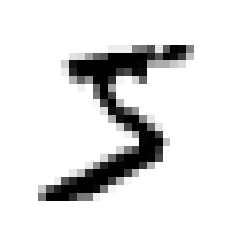

5


In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()
print(y[0])

In [8]:
#Since ML algo requires numbers as labels, cast y to uint8
y = y.astype(np.uint8)

In [9]:
#Need to split into train/test sets early on. MNIST has already split and shuffled it for us
#Important that training set is shuffled, so each validation fold is similar and contains instances of each type of digit 
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [10]:
#Binary classifier
from sklearn.linear_model import SGDClassifier

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [11]:
sgd_clf.predict([some_digit])

array([ True])

In [14]:
#Implementing cross-validation to give more control than sklearn implementation
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3) #3 folds, so equivalent to 3 fold CV

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


In [15]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [16]:
#above 95% on all folds; however, observe teh results of a dumb classifier which classifies all images as not-5 
#Since only around 10% are 5, always guessing an image is 5 will be right about 90% of the time 
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

In [18]:
#So accuracy is not the preferred performance measure for classifiers, esp fro skewed datasets where some classes are
#much more frequent than others. A better measure is the confusion matrix
#cross_val_predict performs K-fold CV, but instead of returning the evaluation scores like cross_val_score, it returns
#the predictions made on each test fold

from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

array([ True, False, False, ...,  True, False, False])

In [23]:
#Each row of the confusion matrix represents a class, and each column represents a predicted class
#The 1st row is non-5 images (negative class) - 53892 were correctly classified as non-5 (true neg), 687 wrongly
#classified as 5 (false pos), 
#The 2nd row is the 5 images (positive class) - while 1891 were wrongly classed as non-5 (false neg), 3530 correctly 
#classed as 5 (true pos)
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred), "Perfect classifier:", confusion_matrix(y_train_5, y_train_5)

(array([[53892,   687],
        [ 1891,  3530]]),
 'Perfect classifier:',
 array([[54579,     0],
        [    0,  5421]]))

In [27]:
#From the confusion matrix, we can define the precision of the classifier - the accuracy of positive predictions TP/(TP+FP)
#We use this metric alongside recall, also called sensitivity or the true positive rate - the ratio of positive instances
#that are correctly detected by the classifier TP/(TP+FN)

from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred), recall_score(y_train_5, y_train_pred)
#so when the classfier claims an image is a 5, it is correct 83.7%. Meanwhile it only detects 65.1% of the 5s. 


(0.8370879772350012, 0.6511713705958311)

In [28]:
#We can conviniently combine precision and recall into a single metric, the F1 score. It is the harmonic mean of precision
#and recall (regular mean treats all values equally, harmonic mean gives much more weight to low values, hence a classifier
#only has a high F1 score if both recall and precision are high). F1 = 2/(1/precision + 1/recall)

from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)
#F1 score favors classfiers with similar precision and recall, although this is not always what you want. High recall
#is desirable for a security system, even if there are lots of false alerts, all threats will be caught) while high
#precision is desirable in a filter for kids videos (you can afford to reject many good ones, keeping only definite safe
#ones). Precision and recall also have a trade off, as one increases the other decreases, with a meeting point inbetween.

0.7325171197343846

In [30]:
#It is possible to change the threshold above which the classifier determines an instance to be a positive case. The
#decision function determines a score and the location of the threshold determines if the instance is positive or negative.
#By default, the SGD classifier has threshold of 0.

y_scores = sgd_clf.decision_function([some_digit])
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred #raising the threshold decreases recall, but increases precision

array([False])

In [32]:
#To decide on a threshold:

from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method='decision_function')

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
len(precisions), len(recalls), len(thresholds)

(59967, 59967, 59966)

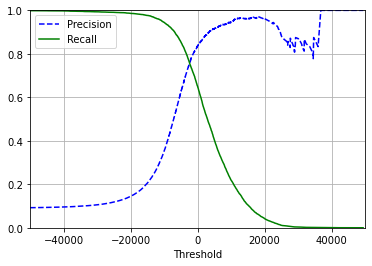

In [36]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel("Threshold")
    plt.xlim(-50000,50000)
    plt.ylim(0.,1.)
    plt.grid()
    plt.legend()

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()
#See Figure 3-3 to find out why precision is bumpy/does not always rise with increased threshold, but does on the whole

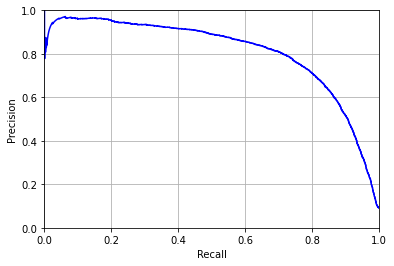

In [41]:
#Sharp dip in precision after around 80% recall
plt.plot(recalls, precisions, 'b-')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim(0.,1.)
plt.ylim(0.,1.)
plt.grid()
plt.show()

In [42]:
#If you want 90% precision, can see from graph it is around 8000 threshold
#Here, argmax returns the location of first True value, which will be the lowest threshold giving 90%

threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] 

#y_scores is the array with the results of the decision function for each instance
y_train_pred_90 = (y_scores >= threshold_90_precision)

precision_score(y_train_5, y_train_pred_90), recall_score(y_train_5, y_train_pred_90)

(0.9000345901072293, 0.4799852425751706)

In [43]:
#An ROC (reciever operating characteristic) curve is often used with binary classifiers - it is similar to the precision-
#recall curve, but instead plots the TPR (true pos rate, i.e. recall) against the FPR (false pos rate). The FPR is equal 
#to 1-TNR, the true neg rate (the ratio of negative instances correctly classified as negative). The TNR is also called
#specificity, so the ROC curve plots sensitivity (recall) against 1-specificity.

from sklearn.metrics import roc_curve
#roc_curve computes the TPR and FPR for various threshold values
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

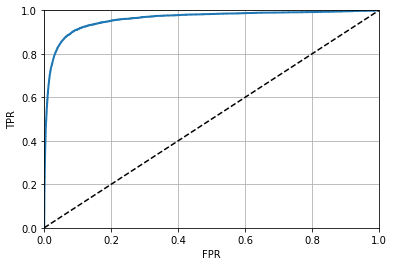

In [45]:
#So, the higher the recall (TPR), the more false positives (FPR) the classifier produces. The dotted line is the
#ROC curve of a random classifier - a good classifier stays as far away as possible from this line (so, top-left corner)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.xlim(0.,1.)
    plt.ylim(0.,1.)
    plt.grid()

plot_roc_curve(fpr, tpr)
plt.show()

In [46]:
#It is possible to compare classifiers by measureing the area under the curve (AUC), a perfect classifier has a ROC AUC = 1
#and a purely random classifier AUC = 0.5

from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

#In general, you should prefer the PR curve whenever the postive class is rare or when you care more about false pos than
#about false neg. Otherwise, use the ROC curve. Given an AUC of 0.96, the classifier seems good, but this is mostly because
#there are few positives (5s) compared to negatives (non-5s). In contrast, the PR curve makes it clear the classifier
#has room for imporvement (the curve could be closer to the top left corner).

0.9604938554008616

In [47]:
#Now train a RandomForestClassifier and compare to ROC and ROC AUC score to the above SGDClassifier. However, the 
#RandomForestCLassifier does not have a decision_function() method we can use to get the scores, instead it has a 
#predict_proba() method, returning an array containing a row per instance and column per class, each element is a prob
#of the instance belonging to each class.

from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                   method='predict_proba')

In [48]:
y_scores_forest = y_probas_forest[:, 1] #score = proba of positive class
#roc_curve() expects labels and scores, but can give it class probablities instead of scores
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

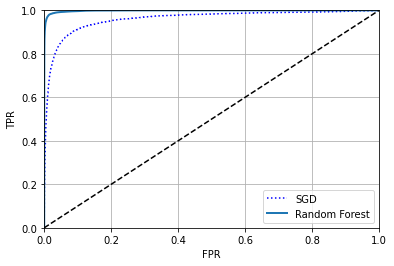

0.9983436731328145


In [63]:
#Plotting both ROC curves we see that the RF is superior to SGD as its curve is closer to the top-left corner + larger AUC
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc='lower right')
plt.show()
print(roc_auc_score(y_train_5, y_scores_forest))

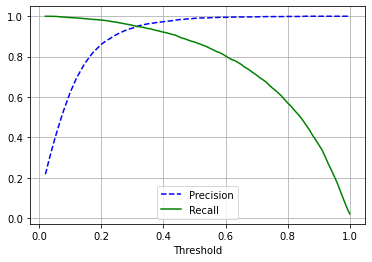

0.9460550458715596 0.9511160302527208


In [68]:
precisions_f, recalls_f, thresholds_f = precision_recall_curve(y_train_5, y_scores_forest)

plt.plot(thresholds_f, precisions_f[:-1], 'b--', label='Precision')
plt.plot(thresholds_f, recalls_f[:-1], 'g-', label='Recall')
plt.xlabel("Threshold")
plt.grid()
plt.legend(loc='lower center')
plt.show()

y_scores_forest_bound = (y_scores_forest > 0.3)
print(precision_score(y_train_5, y_scores_forest_bound), recall_score(y_train_5, y_scores_forest_bound))

In [69]:
#Multiclass classification can be done with different strategies:
#(1) OvR (one versus the rest) where you train 10 binary classifiers, one for each dgiit, and compare decision scores,
#picking the class whose classifier outputs the highest score
#(2) OvO (one versus one) where you train a binary classifier for each pair of digits, so for N classes, train N(N-1)/2
#classifiers (for N=10, 45 classifiers) and see which class wins the most duels. The advantage is that each classifier
#only needs to be trained on the part of the training set for the two classes it needs to distinguish.
#SVMs work better with OvO since they scale badly with the number of training examples. For most binary classification
#algorithms, however, OvR is preferred. N.B. skleaern detects when you try to use a binary classification algo for a 
#multi-class task and automatically runs OvR or OvO depending on the algorithm

from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [71]:
#Notice the decision_function() outputs 10 scores per instance, one for every class
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores, svm_clf.classes_, svm_clf.classes_[np.argmax(some_digit_scores)]

(array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
          9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 5)

In [72]:
#Can force the use of OvO or OvR using the respective classes
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit]), len(ovr_clf.estimators_)

(array([5], dtype=uint8), 10)

In [73]:
#Training a multiclass SGDClassifier or RandomForestClassifier is just as easy. Note SGD and RF classifiers can
#handle multiclass classification natively, so sklearn does not have to run OvR or OvO. The decision_function() method
#now returns one value per class (per instance).
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [77]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [78]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [80]:
#Scores of around 85%, better than random guessing which would give 10%. Can increase accuracy by simply
#using feature scaling on the inputs, giving us an accuracy closer to 90%
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

In [82]:
#To identify the types of errors a (multi)classification model makes, need to look at the confusion matrix

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

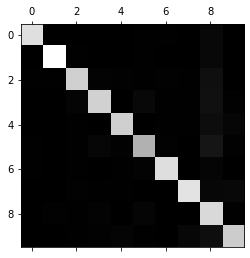

In [83]:
#Generally better to look at a pictoral representation of the confusion matrix. Most images are on the main diagonal, 
#so they were classified correctly. The 5s are slightly darker, either meaning fewer 5s in the dataset or that the 
#classifier does not perform as well on 5s as other digits (here, both are the case).
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

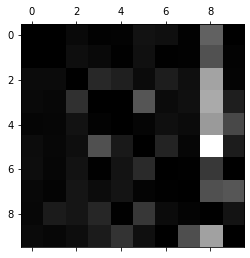

In [84]:
#To focus the plot on the errors, need to divide each value by the number of images in the corresponding class 
#to compare error rates instead of absolute errors (which make abundant classes look unfairly bad). 

row_sums = conf_mx.sum(axis=1, keepdims=True) #axis=1 so that we get the sum of each row (it 'gets rid of' the columns)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [85]:
#You can clearly see the kinds of errors the classifier makes. Remember that rows represent
#actual classes, while columns represent predicted classes. The column for class
#8 is quite bright, which tells you that many images get misclassified as 8s. However,
#the row for class 8 is not that bad, telling you that actual 8s in general get properly
#classified as 8s. As you can see, the confusion matrix is not necessarily symmetrical.
#You can also see that 3s and 5s often get confused (in both directions).
#Analyzing the confusion matrix often gives you insights into ways to improve your
#classifier. Looking at this plot, it seems that your efforts should be spent on reducing
#the false 8s. For example, you could try to gather more training data for digits that
#look like 8s (but are not) so that the classifier can learn to distinguish them from real
#8s. Or you could engineer new features that would help the classifier—for example,
#writing an algorithm to count the number of closed loops (e.g., 8 has two, 6 has one, 5
#has none). Or you could preprocess the images (e.g., using Scikit-Image, Pillow, or
#OpenCV) to make some patterns, such as closed loops, stand out more.

In [87]:
#Multilabel classification - not all classifiers support it, but KNN does

from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train%2 == 1)
y_multilabel= np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [88]:
y_multilabel

array([[False,  True],
       [False, False],
       [False, False],
       ...,
       [False,  True],
       [False, False],
       [ True, False]])

In [89]:
knn_clf.predict([some_digit]) #correct, 5 is not large and is odd.

array([[False,  True]])

In [98]:
#To measure performance of the classifier, we can measure the F1 score for each label (or any binary classifier metric),
#then compute the average. In general the approach depends on the project. The below code assumes all labels are equally
#important; however, if you have more pictures of person A than B or C, you may want to give more weight to the classifiers
#score on pictures of A. Can do this by specifying average='weighted', which gives each label a weight equal to its
#support (i.e. the number of instances with that target label).

y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.976410265560605

In [92]:
#Multioutput classification - a generalization of multilabel where each label can be multiclass (have more than 2 values).
#An example is an image denoiser - takes noisy digit image as input and outputs clean digit image, represented by an 
#array of pixel intensities; hence, we have a multilabel (one label per pixel) problem where each label can have many
#possible values (pixel intensity ranges from 0 to 255).

#create training and test sets
noise = np.random.randint(0, 100, (len(X_train), 784)) #one for each instance, for every pixel (each image is a row vector)
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test
                          
                          
knn_clf.fit(X_train_mod, y_train_mod)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

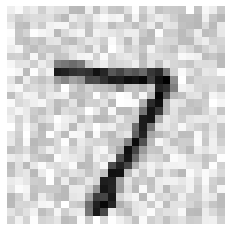

In [94]:
some_index=0
noisy_digit_image = X_test_mod[some_index].reshape(28, 28)
target_digit_image = y_test_mod[some_index].reshape(28, 28)

plt.imshow(noisy_digit_image, cmap='binary')
plt.axis('off')
plt.show()

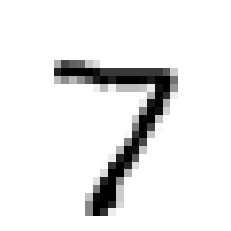

In [95]:
plt.imshow(target_digit_image, cmap='binary')
plt.axis('off')
plt.show()

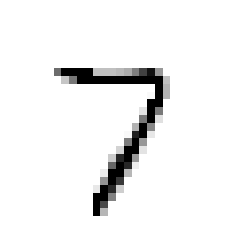

In [97]:
clean_digit = knn_clf.predict([X_test_mod[some_index]])
clean_digit_image = clean_digit.reshape(28, 28)

plt.imshow(clean_digit_image, cmap='binary')
plt.axis('off')
plt.show()